 This question should be answered using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1, 089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

In [5]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

In [6]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [7]:
weekly = load_data('Weekly')

In [8]:
weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [9]:
weekly.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

(a) Produce some numerical and graphical summaries of the Weekly
data. Do there appear to be any patterns?

In [10]:
weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


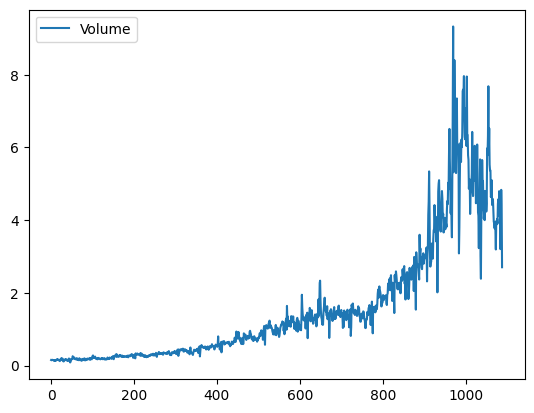

In [11]:
weekly.plot(y = 'Volume');

(b) Use the full data set to perform a logistic regression with
Direction as the response and the five lag variables plus Volume
as predictors. Use the summary function to print the results. Do
any of the predictors appear to be statistically significant? If so,
which ones?

In [12]:
allvars = weekly.columns.drop(['Today','Year','Direction'])
design = MS(allvars)
x = design.fit_transform(weekly)
y = weekly.Direction == 'Up'
glm = sm.GLM(y,x,family=sm.families.Binomial())
results = glm.fit()
summarize(results)
# y[:10]

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


现在看来似乎 Lag2 的p值很低，可能有statically significant

(c) Compute the confusion matrix and overall fraction of correct
predictions. Explain what the confusion matrix is telling you
about the types of mistakes made by logistic regression.

In [13]:
probs = results.predict()
probs[:10]

array([0.60862494, 0.60103144, 0.58756995, 0.48164156, 0.61690129,
       0.56841902, 0.57860971, 0.51519724, 0.57151998, 0.55542873])

In [14]:
label = np.array(['Down']*1089)
label[probs>0.5] = "Up"

In [15]:
confusion_table(label,weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [16]:
np.mean(label == weekly.Direction)

0.5610651974288338

In [17]:
(54 + 557) / 1089

0.5610651974288338

Explain what the confusion matrix is telling you
about the types of mistakes made by logistic regression.
我理解出错的原因是因为 train set 和 test set 一样导致的

(d) Now fit the logistic regression model using a training data period
from 1990 to 2008, with Lag2 as the only predictor. Compute the
confusion matrix and the overall fraction of correct predictions
for the held out data (that is, the data from 2009 and 2010).

In [18]:
train = (weekly.Year < 2009)
weekly_train = weekly.loc[train]
weekly_test = weekly.loc[~train]
weekly_test.shape

(104, 9)

In [19]:
# Lag2_train,Lag2_test = weekly.Lag2[train],weekly.Lag2[~train]
x_train, x_test = x.loc[train], x.loc[~train]
y_train,y_test = y[train],y[~train]
glm_train = sm.GLM(y_train,x_train,family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=x_test)


Lag2_train,Lag2_test = weekly.Lag2[train],weekly.Lag2[~train]
这里调了20分钟！！！！原因居然是weekly.Lag2[train] != x.loc[train]。原因是x是design matrix

In [20]:
D = weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [21]:
label = np.array(['Down']*104)
label[probs>0.5] = 'Up'
confusion_table(label,L_test)

Truth,Down,Up
Predicted,,
Down,31,44
Up,12,17


In [22]:
np.mean(label == L_test),np.mean(label != L_test)

(0.46153846153846156, 0.5384615384615384)

(e) Repeat (d) using LDA.

In [23]:
lda = LDA(store_covariance=True)


In [24]:
x_train, x_test = [M.drop(columns=['intercept'])
                   for M in [x_train, x_test]]
lda.fit(x_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [25]:
lda_pred = lda.predict(x_test)

In [26]:
confusion_table(lda_pred,L_test)

Truth,Down,Up
Predicted,,
Down,31,44
Up,12,17


In [27]:
# np.mean(lda_pred == weekly.Direction)
np.mean(lda_pred == L_test)

0.46153846153846156

In [28]:
(31 + 17)/ 104

0.46153846153846156

In [29]:
31 + 44 + 12 + 17

104

(f) Repeat (d) using QDA.

In [30]:
qda = QDA()
qda.fit(x_train, L_train)


QuadraticDiscriminantAnalysis()

In [31]:
qda_pred = qda.predict(x_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,33,49
Up,10,12


In [32]:
np.mean(qda_pred == L_test)


0.4326923076923077

(h) Repeat (d) using naive Bayes.

In [33]:
NB = GaussianNB()
NB.fit(x_train, L_train)



GaussianNB()

In [34]:
nb_labels = NB.predict(x_test)
confusion_table(nb_labels, L_test)



Truth,Down,Up
Predicted,,
Down,42,56
Up,1,5


In [35]:
np.mean(nb_labels == L_test)

0.4519230769230769

(g) Repeat (d) using KNN with K = 1.

In [36]:
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [x_train, x_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,21,32
Up,22,29


In [37]:
np.mean(knn1_pred == L_test)

0.4807692307692308

(i) Which of these methods appears to provide the best results on
this data?

这里我想画一个类似书中P165 的 boxplot ，这样就能够一眼看到区别

In [38]:
rng = np.random.default_rng(1)
A = rng.standard_normal((127, 5))
M = rng.choice([0, np.nan], p=[0.8,0.2], size=A.shape)
A += M
D = pd.DataFrame(A, columns=['food',
                             'bar',
                             'pickle',
                             'snack',
                             'popcorn'])
D[:3]
A?

Type:        ndarray
String form:
[[ 3.45584192e-01  8.21618144e-01  3.30437076e-01 -1.30315723e+00
           nan]
           [           <...> 524000e-01]
           [-3.29131254e-01  1.69017655e+00 -1.88335978e+00 -4.51551059e-01
           9.50756951e-01]]
Length:      127
File:        d:\anaconda3\envs\islp3\lib\site-packages\numpy\__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` modu

In [39]:
knn1_pred?

Type:        ndarray
String form:
['Down' 'Up' 'Up' 'Down' 'Up' 'Down' 'Up' 'Down' 'Up' 'Up' 'Up' 'Up' 'Up'
           'Down' 'Up' 'Down' 'Do <...> n' 'Down' 'Up' 'Down' 'Down' 'Down' 'Up' 'Up'
           'Down' 'Up' 'Down' 'Down' 'Up' 'Down' 'Down' 'Up']
Length:      104
File:        d:\anaconda3\envs\islp3\lib\site-packages\numpy\__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module an

看到这里才发觉到……_pred其实是array,但是其中的内容不是概率，而是'Up' 'Down'，而且boxplot要的是error rate,那么拿这个来当DataFrame可能不行

所以我想这里如果真要画图的话，可能画柱状图比较合适

In [40]:
# A = np.array()

# boxData = pd.DataFrame

In [41]:
print('LDA :' + str(np.mean(lda_pred == L_test)))
print('QDA :' + str(np.mean(qda_pred == L_test)))
print('NB :' + str(np.mean(nb_labels == L_test)))
print('KNN-1 :' + str(np.mean(knn1_pred == L_test)))

LDA :0.46153846153846156
QDA :0.4326923076923077
NB :0.4519230769230769
KNN-1 :0.4807692307692308


MY ANSWER:'LDA' AND 'Logistic regression' is better

(j) Experiment with different combinations of predictors, including
possible transformations and interactions, for each of the
methods. Report the variables, method, and associated confusion
matrix that appears to provide the best results on the held
out data. Note that you should also experiment with values for
K in the KNN classifier.

In [42]:
# feature_df = weekly.columns['Lag2']
# feature_df = weekly.columns[2]
feature_df = weekly.drop(columns=['Year','Lag1','Lag3','Direction','Lag4', 'Lag5', 'Volume', 'Today'])
# weekly.columns
feature_df

# test = weekly.loc[['Lag2']]
test = weekly[['Lag2']]
# if test == feature_df :
#     print('Yes')
# test?
# feature_df?
test.columns

Index(['Lag2'], dtype='object')

上面这里是在想找到一种不用weely.drop() 的方式来进行 .fit() 。最后在Ch02- 中找到正确的方法

In [43]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)

In [44]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [45]:
feature_std = pd.DataFrame(
                 X_std,
                 columns=test.columns);
feature_std.std()



Lag2    1.000459
dtype: float64

In [46]:
Direction = weekly.Direction

In [47]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(np.asarray(feature_std),
                            Direction,
                            test_size=1000,
                            random_state=0)



In [48]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(0.49, 1.0)

In [49]:
confusion_table(knn1_pred, y_test)


Truth,Down,Up
Predicted,,
Down,231,281
Up,209,279


In [50]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to Up: {1:>2},' +
            '  # who did Up {2:d}, accuracy {3:.1%}')
    pred = C.loc['Up'].sum()
    did_rent = C.loc['Up','Up']
    print(templ.format(
          K,
          pred,
          did_rent,
          did_rent / pred))


K=1: # predicted to Up: 488,  # who did Up 279, accuracy 57.2%
K=2: # predicted to Up: 280,  # who did Up 168, accuracy 60.0%
K=3: # predicted to Up: 526,  # who did Up 301, accuracy 57.2%
K=4: # predicted to Up: 412,  # who did Up 232, accuracy 56.3%
K=5: # predicted to Up: 542,  # who did Up 310, accuracy 57.2%


In [51]:
168/280

0.6

14. In this problem, you will develop a model to predict whether a given
car gets high or low gas mileage based on the Auto data set.

In [52]:
Auto = load_data('Auto')

(a) Create a binary variable, mpg01, that contains a 1 if mpg contains
a value above its median, and a 0 if mpg contains a value below
its median. You can compute the median using the median()
method of the data frame. Note you may find it helpful to add
a column mpg01 to the data frame by assignment. Assuming you
have stored the data frame as Auto, this can be done as follows:

In [53]:
Auto[:10]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190,3850,8.5,70,1,amc ambassador dpl


In [54]:
Auto[380:]



,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
380,25.0,6,181.0,110,2945,16.4,82,1,buick century limited
381,38.0,6,262.0,85,3015,17.0,82,1,oldsmobile cutlass ciera (diesel)
382,26.0,4,156.0,92,2585,14.5,82,1,chrysler lebaron medallion
383,22.0,6,232.0,112,2835,14.7,82,1,ford granada l
384,32.0,4,144.0,96,2665,13.9,82,3,toyota celica gt
385,36.0,4,135.0,84,2370,13.0,82,1,dodge charger 2.2
386,27.0,4,151.0,90,2950,17.3,82,1,chevrolet camaro
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage


In [55]:
np.median(Auto['mpg'])

22.75

In [56]:
Auto['mpg01'] = np.where(Auto['mpg'] > np.median(Auto['mpg']),1,0)

Auto['mpg01']

0      0
1      0
2      0
3      0
4      0
      ..
387    1
388    1
389    1
390    1
391    1
Name: mpg01, Length: 392, dtype: int32

这里本来想在Ch02- 中找引导的，结果发现原来加就在自己写的02.ipynb 中！！！！原来优秀的教材是这样引导着学生一步步解决问题的呀！！！

(b) Explore the data graphically in order to investigate the association
between mpg01 and the other features. Which of the other
features seem most likely to be useful in predicting mpg01? Scatterplots
and boxplots may be useful tools to answer this question.
Describe your findings.

array([[<Axes: xlabel='mpg', ylabel='mpg'>,
        <Axes: xlabel='cylinders', ylabel='mpg'>,
        <Axes: xlabel='displacement', ylabel='mpg'>,
        <Axes: xlabel='horsepower', ylabel='mpg'>,
        <Axes: xlabel='weight', ylabel='mpg'>,
        <Axes: xlabel='acceleration', ylabel='mpg'>,
        <Axes: xlabel='year', ylabel='mpg'>,
        <Axes: xlabel='origin', ylabel='mpg'>,
        <Axes: xlabel='mpg01', ylabel='mpg'>],
       [<Axes: xlabel='mpg', ylabel='cylinders'>,
        <Axes: xlabel='cylinders', ylabel='cylinders'>,
        <Axes: xlabel='displacement', ylabel='cylinders'>,
        <Axes: xlabel='horsepower', ylabel='cylinders'>,
        <Axes: xlabel='weight', ylabel='cylinders'>,
        <Axes: xlabel='acceleration', ylabel='cylinders'>,
        <Axes: xlabel='year', ylabel='cylinders'>,
        <Axes: xlabel='origin', ylabel='cylinders'>,
        <Axes: xlabel='mpg01', ylabel='cylinders'>],
       [<Axes: xlabel='mpg', ylabel='displacement'>,
        <Axes: xlab

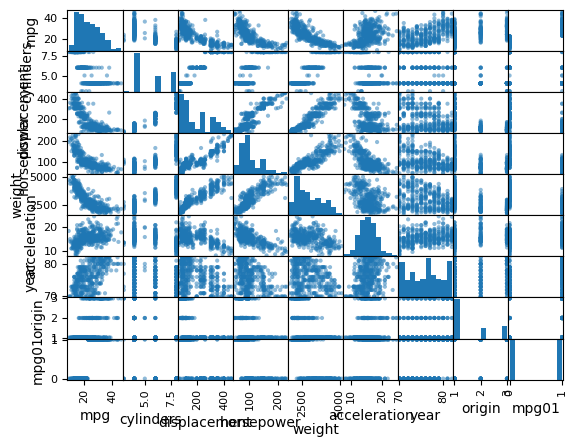

In [57]:
pd.plotting.scatter_matrix(Auto)

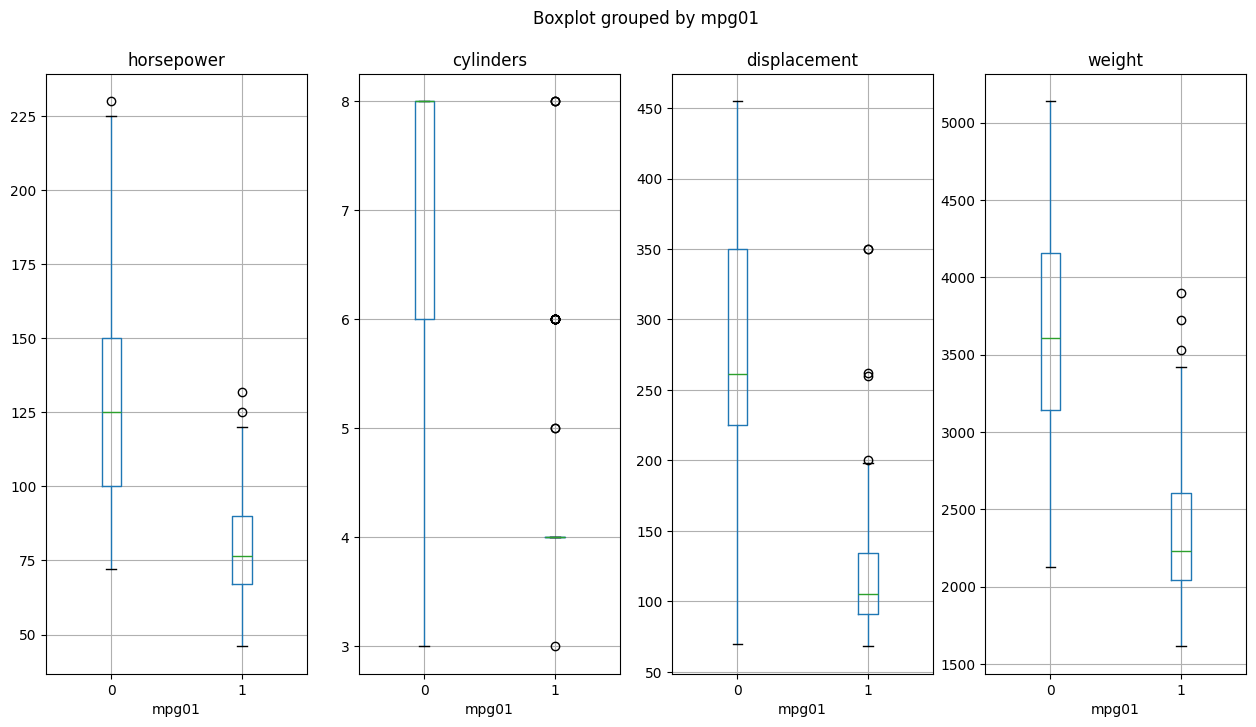

In [58]:
fig, axes = subplots(ncols=4, figsize=(15, 8))
Auto.boxplot('horsepower', 'mpg01', ax=axes[0]);
Auto.boxplot('cylinders', 'mpg01', ax=axes[1]);
Auto.boxplot('displacement', 'mpg01', ax=axes[2]);
Auto.boxplot('weight', 'mpg01', ax=axes[3]);




In [59]:
Auto.corr(numeric_only=True)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209,0.836939
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932,-0.759194
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535,-0.753477
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171,-0.667053
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005,-0.757757
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746,0.346822
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528,0.429904
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000,0.513698
mpg01,0.836939,-0.759194,-0.753477,-0.667053,-0.757757,0.346822,0.429904,0.513698,1.000000


In [60]:
Auto[:10]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg01
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,0
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,0
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,0
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,0
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,0
5,15.0,8,429.0,198,4341,10.0,70,1,ford galaxie 500,0
6,14.0,8,454.0,220,4354,9.0,70,1,chevrolet impala,0
7,14.0,8,440.0,215,4312,8.5,70,1,plymouth fury iii,0
8,14.0,8,455.0,225,4425,10.0,70,1,pontiac catalina,0
9,15.0,8,390.0,190,3850,8.5,70,1,amc ambassador dpl,0


(c) Split the data into a training set and a test set.

In [61]:
np.unique(Auto['year'])

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82], dtype=int64)

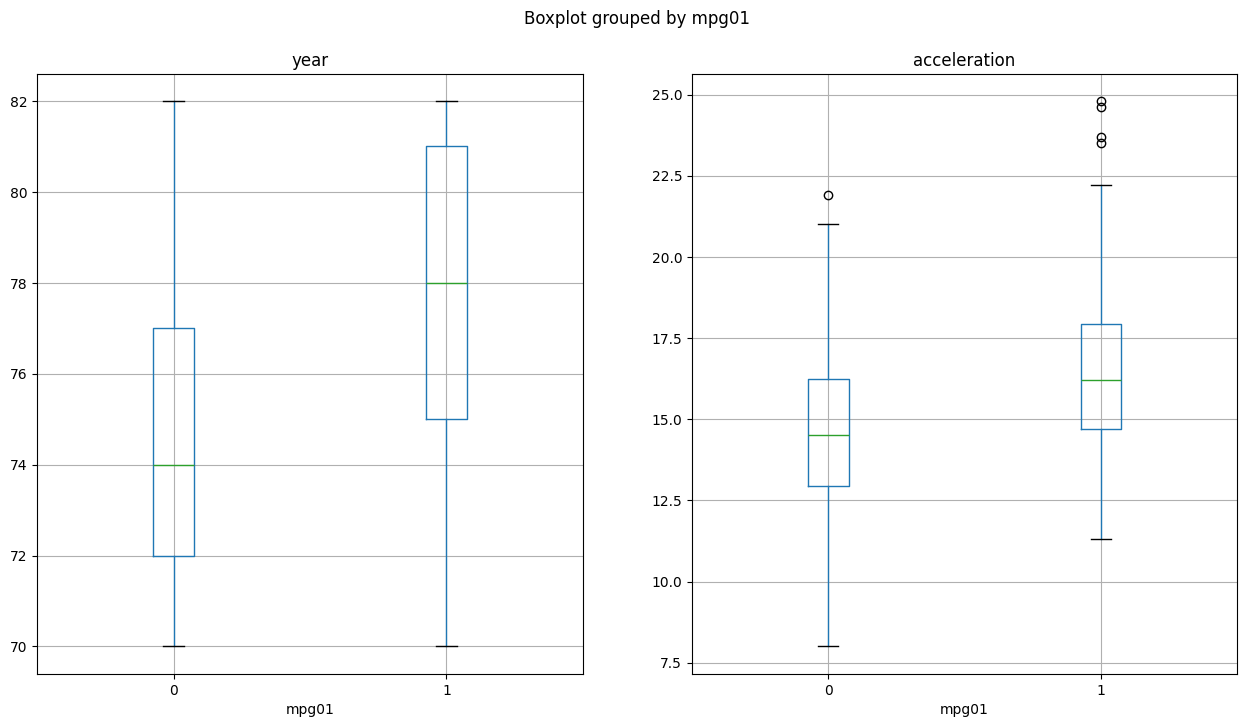

In [62]:
fig, axes = subplots(ncols=2,figsize=(15, 8))
Auto.boxplot('year', 'mpg01',ax=axes[0]);
Auto.boxplot('acceleration', 'mpg01',ax=axes[1]);

In [63]:
Auto.shape

(392, 10)

In [64]:
# mpg01 = Auto.mpg01

In [65]:
# feature_std = 

In [66]:
# (X_train,
#  X_test,
#  y_train,
#  y_test) = train_test_split(np.asarray(feature_std),
#                             mpg01,
#                             test_size=1000,
#                             random_state=0)
Auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name', 'mpg01'],
      dtype='object')

In [67]:
# allvars = Auto[['horsepower','cylinders','displacement','weight']]
allvars = Auto.columns.drop(['year','acceleration','mpg','origin', 'name','mpg01'])
design = MS(allvars)
X = design.fit_transform(Auto)
y = Auto.mpg01 == 1

In [68]:
Train = (Auto.year < 78)

In [69]:
# X_train, X_test = X.loc[train], X.loc[~train]
# y_train, y_test = y.loc[train], y.loc[~train]

这里又调了快15分钟了！原因居然是我忘记了 train 是之前，而为了区别在Auto 的 现在是 Train!

In [70]:
X_train, X_test = X.loc[Train], X.loc[~Train]
y_train, y_test = y.loc[Train], y.loc[~Train]
D = Auto.mpg01
L_train,L_test = D.loc[Train],D.loc[~Train]

(d) Perform LDA on the training data in order to predict mpg01
using the variables that seemed most associated with mpg01 in
(b). What is the test error of the model obtained?

In [71]:
lda_Auto = LDA()

In [72]:
x_train,x_test = [M.drop(columns=['intercept'])
                  for M in [X_train,X_test]]
lda_Auto.fit(x_train,L_train)

LinearDiscriminantAnalysis()

In [73]:
x_test

,cylinders,displacement,horsepower,weight
242,4,90.0,48,1985
243,4,98.0,66,1800
244,4,78.0,52,1985
245,4,85.0,70,2070
246,4,91.0,60,1800
...,...,...,...,...
387,4,140.0,86,2790
388,4,97.0,52,2130
389,4,135.0,84,2295
390,4,120.0,79,2625


In [74]:
lda_pred_Auto = lda_Auto.predict(x_test)

In [75]:
confusion_table(lda_pred_Auto,L_test)

Truth,0,1
Predicted,,
0,35,14
1,4,97


In [76]:
# np.mean(lda_pred_Auto != L_test)
np.mean(lda_pred_Auto == L_test)

0.88

In [77]:
for K in range(71,79):
#     knn = KNeighborsClassifier(n_neighbors=K)
#     knn_pred = knn.fit(X_train, y_train).predict(X_test)
    Train = (Auto.year < K)
    X_train, X_test = X.loc[Train], X.loc[~Train]
    y_train, y_test = y.loc[Train], y.loc[~Train]
    D = Auto.mpg01
    L_train,L_test = D.loc[Train],D.loc[~Train]
    x_train,x_test = [M.drop(columns=['intercept'])
                      for M in [X_train,X_test]]
    lda_Auto = LDA()
    lda_Auto.fit(x_train,L_train)
    lda_pred_Auto = lda_Auto.predict(x_test)
    C = confusion_table(lda_pred_Auto, L_test)
    templ = ('K={0:d}: # predicted to 1: {1:>2},' +
            '  # who did 1 {2:d}, accuracy {3:.1%}')
    pred = C.loc[1].sum()
    did_rent = C.loc[1,1]
    print(templ.format(
          K,
          pred,
          did_rent,
          did_rent / pred))



K=71: # predicted to 1: 200,  # who did 1 175, accuracy 87.5%
K=72: # predicted to 1: 191,  # who did 1 164, accuracy 85.9%
K=73: # predicted to 1: 173,  # who did 1 154, accuracy 89.0%
K=74: # predicted to 1: 151,  # who did 1 143, accuracy 94.7%
K=75: # predicted to 1: 142,  # who did 1 133, accuracy 93.7%
K=76: # predicted to 1: 131,  # who did 1 123, accuracy 93.9%
K=77: # predicted to 1: 117,  # who did 1 111, accuracy 94.9%
K=78: # predicted to 1: 101,  # who did 1 97, accuracy 96.0%


In [78]:
C

Truth,0,1
Predicted,,
0,35,14
1,4,97


NBBBBBBBBBBBBBBBB!!!!!不过range(70,83) 是不对的 调的最不容易发现的一个，应该是range(71,83)

这里又发现有点之前没发觉不同的地方：1、 error rate 和 accuracy 其实不是一个东西 ： error rate 的计算方法是 (35 + 97)/(35 + 14 + 4 + 97) ，accuracy的计算方式是(97)/(97 + 97 + 4) 

In [79]:
for K in range(71,79):
#     knn = KNeighborsClassifier(n_neighbors=K)
#     knn_pred = knn.fit(X_train, y_train).predict(X_test)
    Train = (Auto.year < K)
    X_train, X_test = X.loc[Train], X.loc[~Train]
    y_train, y_test = y.loc[Train], y.loc[~Train]
    D = Auto.mpg01
    L_train,L_test = D.loc[Train],D.loc[~Train]
    x_train,x_test = [M.drop(columns=['intercept'])
                      for M in [X_train,X_test]]
    lda_Auto = LDA(store_covariance=True)
    lda_Auto.fit(x_train,L_train)
    lda_pred_Auto = lda_Auto.predict(x_test)
    C = confusion_table(lda_pred_Auto, L_test)
    templ = ('K={0:d}: # error rate {1:>2}')
#     pred = C.loc[0,0] + C.loc[1,1]
#     did_rent = C.loc[0] + C.loc[1]
    print(templ.format(
          K,
        #   pred,
        #   did_rent,
          np.mean(lda_pred_Auto == L_test)))

K=71: # error rate 0.8925619834710744
K=72: # error rate 0.8779761904761905
K=73: # error rate 0.8863636363636364
K=74: # error rate 0.8917910447761194
K=75: # error rate 0.8966942148760331
K=76: # error rate 0.8915094339622641
K=77: # error rate 0.8932584269662921
K=78: # error rate 0.88


(e) Perform QDA on the training data in order to predict mpg01
using the variables that seemed most associated with mpg01 in
(b). What is the test error of the model obtained?

In [80]:
qda_Auto = QDA(store_covariance=True)
qda_Auto.fit(x_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [81]:
qda_pred_Auto = qda_Auto.predict(x_test)
confusion_table(qda_pred_Auto,L_test)

Truth,0,1
Predicted,,
0,36,19
1,3,92


(f) Perform logistic regression on the training data in order to predict
mpg01 using the variables that seemed most associated with
mpg01 in (b). What is the test error of the model obtained?

In [82]:
allvars = Auto.columns.drop(['year','acceleration','mpg','origin', 'name','mpg01'])
design = MS(allvars)
X = design.fit_transform(Auto)
y = Auto.mpg01 == 1

In [83]:
Train = (Auto.year < 78)

In [84]:
X_train, X_test = X.loc[Train], X.loc[~Train]
y_train, y_test = y.loc[Train], y.loc[~Train]
D = Auto.mpg01
L_train,L_test = D.loc[Train],D.loc[~Train]

In [85]:
X_test.shape

(150, 5)

In [86]:
glm_train = sm.GLM(y_train,X_train,family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [87]:
results = glm_train.fit()
# probs = results.predict(x_test)
summarize(results)


,coef,std err,z,P>|z|
intercept,13.9964,2.866,4.884,0.000
cylinders,-0.0525,0.650,-0.081,0.936
displacement,-0.0178,0.015,-1.150,0.250
horsepower,-0.0471,0.024,-1.925,0.054
weight,-0.0027,0.001,-2.271,0.023


In [88]:
results.params

intercept       13.996384
cylinders       -0.052483
displacement    -0.017762
horsepower      -0.047126
weight          -0.002661
dtype: float64

In [89]:
labels = np.array([0]*150)
labels[probs>0.5] = 1

In [90]:
confusion_table(labels,L_test)

Truth,0,1
Predicted,,
0,38,32
1,1,79


In [91]:
# np.mean(label != L_test)

In [92]:
1 + 32 + 38 + 79

150

In [93]:
(32 + 1) / 150

0.22

这里不知道调了多久了！！！！！原因居然是在设置变量的时候 allvars = Auto.columns.drop(['year','acceleration','mpg','origin', 'name']) 题目是predict mpg01 ,但是我们设置 allvars 的时候却没有将 mpg01 drop出去！！！，所以导致了最后出现了 PerfectSeparationWarning （即完美拟合）

这里感谢stackoverflow一位网友的回答：Probably this may help someone who is a noob like me!
也许这可以帮助像我这样的菜鸟！

Make sure that you are not including the target along with the predictors. I accidentally included the target along with the predictors and struggled with this for a long time, for such a silly mistake.
确保您没有将 target 与 predictors 一起包含在内。我不小心将 target 与 predictors 一起包含在内，并为此挣扎了很长时间，因为这是一个愚蠢的错误。

Explanation: Since the target which you included along with the predictors is in perfect correlation with itself, it would give you a Perfect separation detected error.
说明：由于您与 predictors 一起包含的 target 与其自身完全相关，因此它会给您一个完美分离检测到的错误。

(g) Perform naive Bayes on the training data in order to predict
mpg01 using the variables that seemed most associated with mpg01
in (b). What is the test error of the model obtained?

In [94]:
NB = GaussianNB()
NB.fit(X_train, L_train)



GaussianNB()

In [95]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)



Truth,0,1
Predicted,,
0,36,13
1,3,98


In [96]:
np.mean(nb_labels != L_test)

0.10666666666666667

(h) Perform KNN on the training data, with several values of K, in
order to predict mpg01. Use only the variables that seemed most
associated with mpg01 in (b). What test errors do you obtain?
Which value of K seems to perform the best on this data set?

In [97]:
for K in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # error rate {1:>2}')
#     pred = C.loc[0] + C.loc[1]
#     did_rent = C.loc[0,0] + C.loc[1,1]
    print(templ.format(
          K,
        #   pred,
        #   did_rent,
          np.mean(knn_pred != L_test)))


K=1: # error rate 0.19333333333333333
K=2: # error rate 0.23333333333333334
K=3: # error rate 0.19333333333333333
K=4: # error rate 0.22
K=5: # error rate 0.16666666666666666
K=6: # error rate 0.20666666666666667
K=7: # error rate 0.19333333333333333
K=8: # error rate 0.21333333333333335
K=9: # error rate 0.19333333333333333


MY ANSWER: K = 5

## 15. This problem involves writing functions.

(a) Write a function, Power(), that prints out the result of raising 2
to the 3rd power. In other words, your function should compute
23 and print out the results.
Hint: Recall that x**a raises x to the power a. Use the print()
function to display the result.

In [98]:
def Power():
    res = 2 ** 3
    print(res)

In [99]:
Power()

8


(b) Create a new function, Power2(), that allows you to pass any
two numbers, x and a, and prints out the value of x**a. You can
do this by beginning your function with the line

In [100]:
def Power2(x,a):
    res = x ** a 
    print(res)

In [101]:
Power2(3,8)

6561


(c) Using the Power2() function that you just wrote, compute 103,
817, and 1313.

In [102]:
Power2(10,3),Power2(8,17),Power2(131,3)

1000
2251799813685248
2248091


(None, None, None)

(d) Now create a new function, Power3(), that actually returns the
result x**a as a Python object, rather than simply printing it
to the screen. That is, if you store the value x**a in an object
called result within your function, then you can simply return return this result, using the following line:
return result
Note that the line above should be the last line in your function,
and it should be indented 4 spaces.

In [103]:
def Power3(x,a):
    res = x ** a 
    return res

(e) Now using the Power3() function, create a plot of f(x) = x2.
The x-axis should display a range of integers from 1 to 10, and
the y-axis should display x2. Label the axes appropriately, and
use an appropriate title for the figure. Consider displaying either
the x-axis, the y-axis, or both on the log-scale. You can do this
by using the ax.set_xscale() and ax.set_yscale() methods of .set_xscale()
.set_yscale() the axes you are plotting to.

Text(0, 0.5, 'Y-axis')

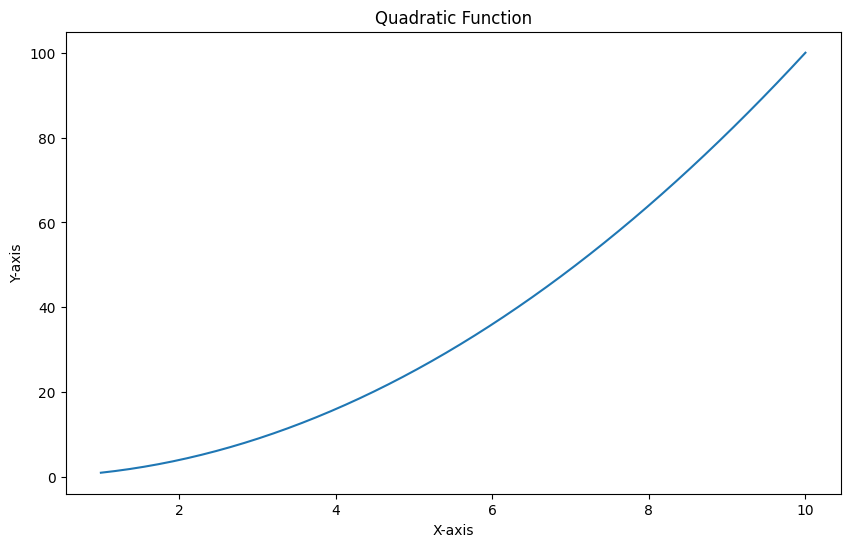

In [104]:
fig,axes = subplots(figsize=[10,6])
X = np.linspace(1,10) 
y = Power3(X,2)
axes.plot(X,y)
axes.set_title("Quadratic Function")
axes.set_xlabel("X-axis")
axes.set_ylabel("Y-axis")

In [105]:
axes.set_xscale?

Signature: axes.set_xscale(value, **kwargs)
Docstring:
Set the xaxis' scale.

Parameters
----------
value : {"linear", "log", "symlog", "logit", ...} or `.ScaleBase`
    The axis scale type to apply.

**kwargs
    Different keyword arguments are accepted, depending on the scale.
    See the respective class keyword arguments:

    - `matplotlib.scale.LinearScale`
    - `matplotlib.scale.LogScale`
    - `matplotlib.scale.SymmetricalLogScale`
    - `matplotlib.scale.LogitScale`
    - `matplotlib.scale.FuncScale`

Notes
-----
By default, Matplotlib supports the above-mentioned scales.
Additionally, custom scales may be registered using
`matplotlib.scale.register_scale`. These scales can then also
be used here.
File:      d:\anaconda3\envs\islp3\lib\site-packages\matplotlib\axes\_base.py
Type:      method

In [106]:
axes.set_xscale('log')
axes.set_yscale('log')


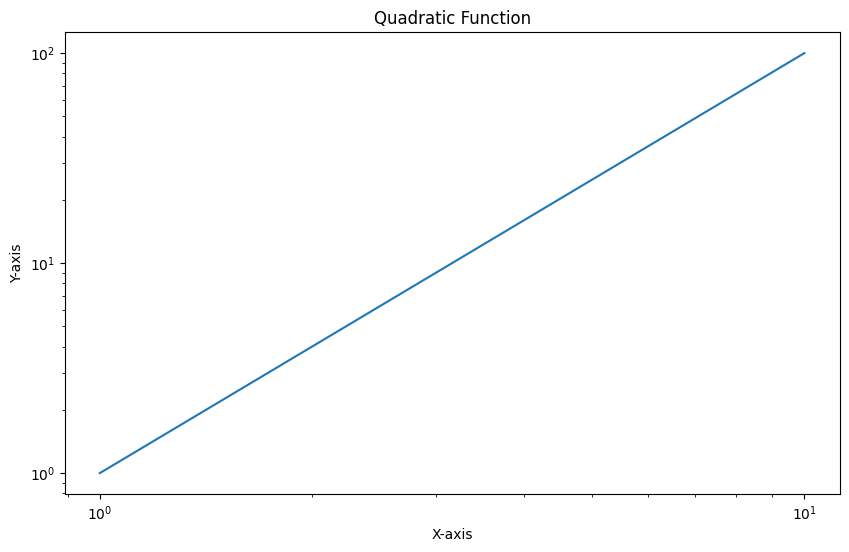

In [107]:
fig

(f) Create a function, PlotPower(), that allows you to create a plot
of x against x**a for a fixed a and a sequence of values of x. For
instance, if you call
PlotPower(np.arange(1, 11), 3)
then a plot should be created with an x-axis taking on values
1, 2, . . . , 10, and a y-axis taking on values 13, 23, . . . , 103.

In [108]:
def PlotPower(seq,a):
    y_arr = []
    # y_arr = lambda x: i**a for i in seq
    for i in seq:
        y_arr.append(i**a)
    fig,ax = subplots(figsize=[10,10])
    ax.plot(seq,y_arr)

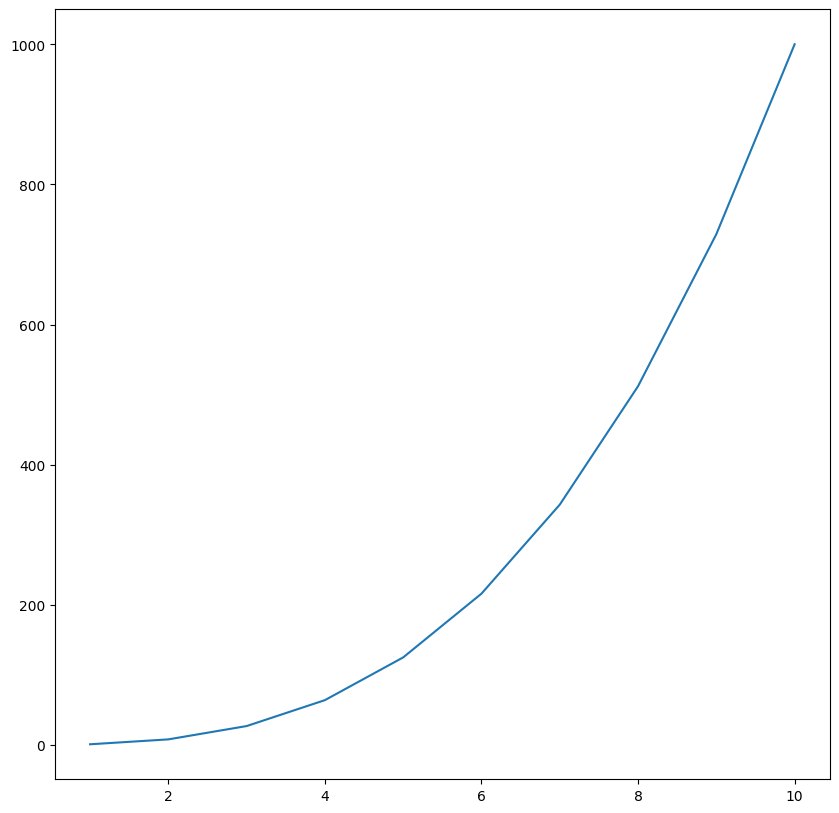

In [109]:
PlotPower(np.arange(1,11),3)

16. Using the Boston data set, fit classification models in order to predict
whether a given suburb has a crime rate above or below the median.
Explore logistic regression, LDA, naive Bayes, and KNN models using
various subsets of the predictors. Describe your findings.
Hint: You will have to create the response variable yourself, using the
variables that are contained in the Boston data set.